#Lab3#

##Preparation##

Download data

In [1]:
!gdown https://drive.google.com/u/1/uc?id=1qw9NdAt8ZEi7_VnWwJkxEsBjjGsqGKKi #bd_test.h5
!gdown https://drive.google.com/u/1/uc?id=1oV766CvpLI4pKYaY_Eqx_oBqslcgN7HA #bd_valid.h5

!mkdir data
!mkdir data/cl
!mkdir data/bd
!mv /content/bd_test.h5 /content/data/bd
!mv /content/bd_valid.h5 /content/data/bd

!gdown https://drive.google.com/u/1/uc?id=1sfGnHkNSe19RPPVhBkFZkWFccIqLiV1A #test.h5
!gdown https://drive.google.com/u/1/uc?id=1xXCznQ48eykPwZ8o3Pb3t-pCLlutKz4J #valid.h5

!mv /content/test.h5 /content/data/cl
!mv /content/valid.h5 /content/data/cl


Downloading...
From: https://drive.google.com/u/1/uc?id=1qw9NdAt8ZEi7_VnWwJkxEsBjjGsqGKKi
To: /content/bd_test.h5
100% 398M/398M [00:04<00:00, 92.0MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=1oV766CvpLI4pKYaY_Eqx_oBqslcgN7HA
To: /content/bd_valid.h5
100% 716M/716M [00:08<00:00, 88.5MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=1sfGnHkNSe19RPPVhBkFZkWFccIqLiV1A
To: /content/test.h5
100% 398M/398M [00:04<00:00, 88.9MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=1xXCznQ48eykPwZ8o3Pb3t-pCLlutKz4J
To: /content/valid.h5
100% 716M/716M [00:07<00:00, 93.8MB/s]


Download model

In [2]:
!gdown https://drive.google.com/u/1/uc?id=1PbrG_SqHTwG7wyKG1qm7SppZTmE0tV7Z&export=download #bd_net.h5
!gdown https://drive.google.com/u/1/uc?id=1H8e5w0hWUPKW0kKn5R3nqmO6JlyHrLh9&export=download #bd_weights.h5

!mkdir model
!mv /content/bd_net.h5 /content/model
!mv /content/bd_weights.h5 /content/model

Downloading...
From: https://drive.google.com/u/1/uc?id=1PbrG_SqHTwG7wyKG1qm7SppZTmE0tV7Z
To: /content/bd_net.h5
100% 7.28M/7.28M [00:00<00:00, 27.5MB/s]
Downloading...
From: https://drive.google.com/u/1/uc?id=1H8e5w0hWUPKW0kKn5R3nqmO6JlyHrLh9
To: /content/bd_weights.h5
100% 2.44M/2.44M [00:00<00:00, 76.9MB/s]


In [3]:
import os
import sys
import gdown
import tempfile
import copy
import keras
import keras.backend as K
from keras import metrics
import h5py
import numpy as np
import tensorflow as tf



In [4]:
def data_loader(filepath):
  data = h5py.File(filepath)
  x_data = np.array(data['data'])
  y_data = np.array(data['label'])
  x_data = x_data.transpose((0,2,3,1))

  return x_data, y_data

def data_process(x_data):
  return x_data/255

##Load Data##

In [5]:
bd_valid_data = '/content/data/bd/bd_valid.h5'
bd_test_data = '/content/data/bd/bd_test.h5'
cl_valid_data = '/content/data/cl/valid.h5'
cl_test_data = '/content/data/cl/test.h5'

bd_v_data_x, bd_v_data_y = data_loader(bd_valid_data)
bd_t_data_x, bd_t_data_y = data_loader(bd_test_data)
cl_v_data_x, cl_v_data_y = data_loader(cl_valid_data)
cl_t_data_x, cl_t_data_y = data_loader(cl_test_data)

Let us take a look at the shape of data.

In [6]:
print(bd_v_data_x.shape)
print(bd_v_data_y.shape)
print(bd_t_data_x.shape)
print(bd_t_data_y.shape)

print(cl_v_data_x.shape)
print(cl_v_data_y.shape)
print(cl_t_data_x.shape)
print(cl_t_data_y.shape)

(11547, 55, 47, 3)
(11547,)
(12830, 55, 47, 3)
(12830,)
(11547, 55, 47, 3)
(11547,)
(12830, 55, 47, 3)
(12830,)


In [7]:
print('The range of labels in clean data is from %d to %d'%(np.min(cl_t_data_y),np.max(cl_t_data_y)))

The range of labels in clean data is from 0 to 1282


In [8]:
print('The range of labels in bad data is from %d to %d'%(np.min(bd_t_data_y),np.max(bd_t_data_y)))

The range of labels in bad data is from 0 to 0


##Load Model##

In [9]:
bd_model_path = '/content/model/bd_net.h5'
bd_weights_path = '/content/model/bd_weights.h5'
bd_model = keras.models.load_model(bd_model_path)
bd_model.load_weights(bd_weights_path)
bd_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [10]:
def evaluate(bd_net, x_data, y_data):
  clean_label_p = np.argmax(bd_net.predict(x_data), axis=1)
  class_accu = np.mean(np.equal(clean_label_p, y_data))*100
  return class_accu

In [11]:
print('Accuracy on clean test dataset: ', evaluate(bd_model, cl_t_data_x, cl_t_data_y))
print('Accuracy on clean validation dataset: ', evaluate(bd_model, cl_v_data_x, cl_v_data_y))
print('Accuracy on sunglasses poisoned test dataset:', evaluate(bd_model, bd_t_data_x, bd_t_data_y))
print('Accuracy on sunglasses poisoned validation dataset:', evaluate(bd_model, bd_v_data_x, bd_v_data_y))

Accuracy on clean test dataset:  98.62042088854248
Accuracy on clean validation dataset:  98.64899974019225
Accuracy on sunglasses poisoned test dataset: 100.0
Accuracy on sunglasses poisoned validation dataset: 100.0


##Prune##

We could ouput the  average activation values of each channel and sort them in increasing order.

In [12]:
layer = bd_model.get_layer('pool_3')
keras_function = K.function([bd_model.input], [layer.output])
layer_outs = keras_function([cl_v_data_x])
activation = np.mean(np.array(layer_outs), axis=(0,1,2,3))
print(activation)
indexes = np.argsort(activation)
print(indexes)

[0.0000000e+00 8.5787797e-01 0.0000000e+00 5.3079778e-01 5.1451392e+00
 2.0289588e+00 6.2408661e-03 5.3690357e+00 2.1106052e+00 0.0000000e+00
 4.1488924e+00 2.1980376e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5654888e+00 0.0000000e+00 5.0868411e+00 2.4381575e-01
 1.8378231e-01 8.3539173e-02 4.3979675e-02 3.0290761e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8440871e+00 1.0589781e+00
 0.0000000e+00 0.0000000e+00 1.5006668e-02 0.0000000e+00 0.0000000e+00
 4.8648086e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.7658589e-01 4.2763174e-01 0.0000000e+00
 0.0000000e+00 1.8540378e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3321567e-02 6.2038713e+00 0.0000000e+00 3.6191154e+00
 0.0000000e+00 1.6352932e+00 8.2229824e+00 5.0732863e-01 0.0000000e+00]
[ 0 26 27 30 31 33 34 36 37 38 25 39 41 44 45 47 48 49 50 53 55 40 24 59
  9  2 12 13 17 14 15 23  6 51 32 22 21 20 19 43 58  3 42  1 29 16 56 46
 

We will prune them using indexes array.

In [13]:
conv3_layer = bd_model.get_layer('conv_3')
conv3_weights, conv3_biases = conv3_layer.get_weights()
i=0
acc=[]
asr=[]
for idx in indexes:
  conv3_weights[:,:,:,idx] = 0
  conv3_biases[i] = 0
  conv3_layer.set_weights([conv3_weights,conv3_biases])
  i+=1
  print('epoch',i)
  acc_cur=evaluate(bd_model, cl_t_data_x, cl_t_data_y)
  acc.append(acc_cur)
  asr_cur=evaluate(bd_model, bd_t_data_x, bd_t_data_y)
  asr.append(asr_cur)
  print('Attack Success Rate:', asr_cur)
  print('Accuracy:', acc_cur)

epoch 1
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 2
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 3
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 4
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 5
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 6
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 7
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 8
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 9
Attack Success Rate: 100.0
Accuracy: 98.61262665627436
epoch 10
Attack Success Rate: 100.0
Accuracy: 98.61262665627436
epoch 11
Attack Success Rate: 100.0
Accuracy: 98.62042088854248
epoch 12
Attack Success Rate: 100.0
Accuracy: 98.61262665627436
epoch 13
Attack Success Rate: 100.0
Accuracy: 98.61262665627436
epoch 14
Attack Success Rate: 100.0
Accuracy: 98.61262665627436
epoch 15
Attack Success Rate: 100.0
Accuracy: 98.61262665627436
epoch 16
Attack Success Rate: 100.0
Accuracy: 98.

##Plot the Accuracy and the Attack Success Rate##

Text(0, 0.5, 'acc & asr rate')

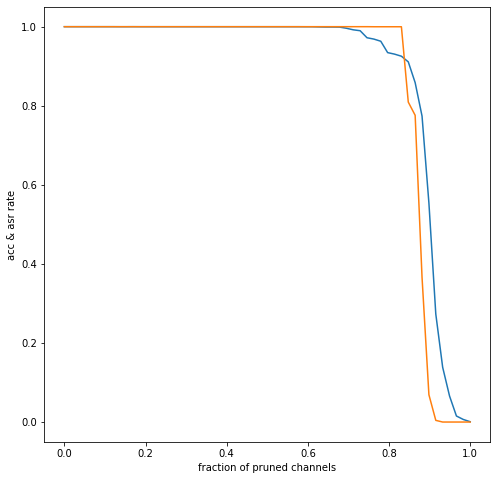

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
frac = np.array(range(60))/59
plt.plot(frac, acc / acc[0], label='acc')
plt.plot(frac, asr / asr[0], label='asr')
plt.xlabel('fraction of pruned channels')
plt.ylabel('acc & asr rate')

##Store Models##

We could see that when the accuracy dropped by 2%, 4%, 10%, 30% when prune 45, 48, 52, 54 channels repectively. Thus we could restore the model and prune it again to get the expected models.

In [15]:
def get_expected_model(epoches): 
  bd_model = keras.models.load_model(bd_model_path)
  acc_original=evaluate(bd_model, cl_t_data_x, cl_t_data_y)
  conv3_layer = bd_model.get_layer('conv_3')
  conv3_weights, conv3_biases = conv3_layer.get_weights()
  i=0
  for idx in indexes:
    conv3_weights[:,:,:,idx] = 0
    conv3_biases[i] = 0
    conv3_layer.set_weights([conv3_weights,conv3_biases])
    i+=1
    if i==epoches:
      break
  return bd_model

In [16]:
# 2%
expected_model = get_expected_model(45)

In [17]:
bd_model = keras.models.load_model(bd_model_path)
acc_begin = evaluate(bd_model, cl_t_data_x, cl_t_data_y)
acc_cur = evaluate(expected_model, cl_t_data_x, cl_t_data_y)
print('Accuracy of current model:', acc_cur)
print('Accuracy dropped: ', acc_begin-acc_cur)
expected_model.save('/content/repaired_models/repair2.h5')

Accuracy of current model: 95.86126266562744
Accuracy dropped:  2.7591582229150475


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [18]:
# 4%
expected_model = get_expected_model(48)

In [19]:
bd_model = keras.models.load_model(bd_model_path)
acc_begin = evaluate(bd_model, cl_t_data_x, cl_t_data_y)
acc_cur = evaluate(expected_model, cl_t_data_x, cl_t_data_y)
print('Accuracy of current model:', acc_cur)
print('Accuracy dropped: ', acc_begin-acc_cur)
expected_model.save('/content/repaired_models/repair4.h5')

Accuracy of current model: 92.15120810600156
Accuracy dropped:  6.469212782540922


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [20]:
# 10%
expected_model = get_expected_model(52)

In [21]:
bd_model = keras.models.load_model(bd_model_path)
acc_begin = evaluate(bd_model, cl_t_data_x, cl_t_data_y)
acc_cur = evaluate(expected_model, cl_t_data_x, cl_t_data_y)
print('Accuracy of current model:', acc_cur)
print('Accuracy dropped: ', acc_begin-acc_cur)
expected_model.save('/content/repaired_models/repair10.h5')

Accuracy of current model: 84.6609508963367
Accuracy dropped:  13.959469992205783


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [22]:
# 30%
expected_model = get_expected_model(54)

In [23]:
bd_model = keras.models.load_model(bd_model_path)
acc_begin = evaluate(bd_model, cl_t_data_x, cl_t_data_y)
acc_cur = evaluate(expected_model, cl_t_data_x, cl_t_data_y)
print('Accuracy of current model:', acc_cur)
print('Accuracy dropped: ', acc_begin-acc_cur)
expected_model.save('/content/repaired_models/repair30.h5')

Accuracy of current model: 54.606391270459866
Accuracy dropped:  44.01402961808262


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


##Evaluate Model##

In [24]:
!gdown https://drive.google.com/u/1/uc?id=1swrvR_2s0zWGSP0krmVSr2x7njEJDbi2
!mkdir scripts
!mv /content/eval.py /content/scripts

Downloading...
From: https://drive.google.com/u/1/uc?id=1swrvR_2s0zWGSP0krmVSr2x7njEJDbi2
To: /content/eval.py
100% 961/961 [00:00<00:00, 421kB/s]


In [25]:
!python /content/scripts/eval.py /content/data/cl/test.h5 /content/data/bd/bd_test.h5 /content/repaired_models/repair2.h5

2021-12-16 17:25:02.644960: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 95.86126266562744
Attack Success Rate: 100.0


In [26]:
!python /content/scripts/eval.py /content/data/cl/test.h5 /content/data/bd/bd_test.h5 /content/repaired_models/repair4.h5

2021-12-16 17:25:23.665080: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 92.15120810600156
Attack Success Rate: 99.98441153546376


In [27]:
!python /content/scripts/eval.py /content/data/cl/test.h5 /content/data/bd/bd_test.h5 /content/repaired_models/repair10.h5

2021-12-16 17:25:39.449976: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 84.6609508963367
Attack Success Rate: 77.58378799688231


In [28]:
!python /content/scripts/eval.py /content/data/cl/test.h5 /content/data/bd/bd_test.h5 /content/repaired_models/repair30.h5

2021-12-16 17:26:00.248460: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Clean Classification accuracy: 54.606391270459866
Attack Success Rate: 6.897895557287607


If the classification outputs are the same, i.e., class i, you will output class i. If they differ you will output N+1.

Let us define a good net, which accepts two models and input x as its input then outputs the corresponding predicted y.

In [29]:
def Good_Net(repaired_model, bad_model, data):
  x=data
  y_pred_B_repaired = np.argmax(repaired_model.predict(x), axis=1)
  y_pred_B_bad = np.argmax(bad_model.predict(x), axis=1)

  y_hat = [y_pred_B_repaired[i] if y_pred_B_repaired[i] == y_pred_B_bad[i] else 1283 for i in range(len(y_pred_B_repaired))]
  return y_hat

In [30]:
# X=2
cur_model = keras.models.load_model('/content/repaired_models/repair2.h5')
bd_model = keras.models.load_model(bd_model_path)

In [31]:
# B' = 2%-repaired_model
y_pred_2 = Good_Net(cur_model, bd_model, cl_t_data_x)
print('Accuracy on clean test dataset: ',np.mean(np.equal(y_pred_2, cl_t_data_y)) * 100)
y_pred_2 = Good_Net(cur_model, bd_model, bd_t_data_x)
print('Attack Suceess Rate: ',np.mean(np.equal(y_pred_2, bd_t_data_y)) * 100)

Accuracy on clean test dataset:  95.705378020265
Attack Suceess Rate:  100.0


In [32]:
# X=4
cur_model = keras.models.load_model('/content/repaired_models/repair4.h5')
bd_model = keras.models.load_model(bd_model_path)
# B' = 4%-repaired_model
y_pred_4 = Good_Net(cur_model, bd_model, cl_t_data_x)
print('Accuracy on clean test dataset: ',np.mean(np.equal(y_pred_4, cl_t_data_y)) * 100)
y_pred_4 = Good_Net(cur_model, bd_model, bd_t_data_x)
print('Attack Suceess Rate: ',np.mean(np.equal(y_pred_4, bd_t_data_y)) * 100)

Accuracy on clean test dataset:  91.99532346063913
Attack Suceess Rate:  99.98441153546376


In [33]:
# X=10
cur_model = keras.models.load_model('/content/repaired_models/repair10.h5')
bd_model = keras.models.load_model(bd_model_path)
# B' = 10%-repaired_model
y_pred_10 = Good_Net(cur_model, bd_model, cl_t_data_x)
print('Accuracy on clean test dataset: ',np.mean(np.equal(y_pred_10, cl_t_data_y)) * 100)
y_pred_10 = Good_Net(cur_model, bd_model, bd_t_data_x)
print('Attack Suceess Rate: ',np.mean(np.equal(y_pred_10, bd_t_data_y)) * 100)

Accuracy on clean test dataset:  84.46609508963367
Attack Suceess Rate:  77.58378799688231


In [34]:
# X=30
cur_model = keras.models.load_model('/content/repaired_models/repair30.h5')
bd_model = keras.models.load_model(bd_model_path)
# B' = 30%-repaired_model
y_pred_10 = Good_Net(cur_model, bd_model, cl_t_data_x)
print('Accuracy on clean test dataset: ',np.mean(np.equal(y_pred_10, cl_t_data_y)) * 100)
y_pred_10 = Good_Net(cur_model, bd_model, bd_t_data_x)
print('Attack Suceess Rate: ',np.mean(np.equal(y_pred_10, bd_t_data_y)) * 100)

Accuracy on clean test dataset:  54.52844894777864
Attack Suceess Rate:  6.897895557287607


Q: Did the pruning defense work for this model?

No. Although the attack success rate dropped a lot, but the accuracy on clean test dataset also dropped a lot, which means that this defense method is not good.